# Preparing data 

# Разметка
Для разметки мы отбирали запросы следующим образом: между векторами двух запросов полученных с помощью [LaBSE](https://huggingface.co/cointegrated/LaBSE-en-ru) смотрели на косинусную близость между ними. Если она ниже 0.7, то брали в разметку толокерами. Остальные запросы считали парафразами. Также мы добавили немного синтетических данных - брали случайные запросы, и если между эмбеддингами косинусная близость меньше 0.2, то считали, что их таргет равен 0.

В инструкции на Толоке мы дали определение парафразы и сформулировали несколько её критериев. Также мы привели много положительных и отрицательных примеров парафраз, чтобы свести к минимуму неясность в постановке задачи.
Для контроля качества мы
- банили на день толокеров, слишком быстро размечающих task suite
- банили на день толокеров, слишком часто неправиьно отвечающих на контрольные задания

(см. подробности в настройках проекта)

# Обучение

В качестве модели мы взяли предобученный [мультиязычный берт](https://huggingface.co/bert-base-multilingual-cased) и дообучали его в конфигурации
 - 100 эпох
 - батч 32
 - паддинг до максимальной длины в батче
 - lr=1e-5

Модель достигла точности 0.95 на валидации и 0.79 в контесте


In [1]:
!nvidia-smi

Fri Nov 11 03:08:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   34C    P0    37W / 250W |   7993MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

In [8]:
!head -100 user_session_million_queries.json >> SMALL_user_session_million_queries.json

In [5]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/jDqKoQ_d5F2_Wg) -o user_session_million_queries.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  574M  100  574M    0     0  39.1M      0  0:00:14  0:00:14 --:--:-- 41.7M


In [1]:
import pandas as pd


def target_renaming(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        raise Exception('bad target')
        
train_df = pd.read_csv('aggregated_results_by_ds__pool_36298501__2022_11_10.tsv', 
                       sep='\t', index_col=None)
train_df = train_df[['INPUT:text1', 'INPUT:text2', 'OUTPUT:result']].rename(columns={'INPUT:text1': 'text_1','INPUT:text2': 'text_2', 'OUTPUT:result': 'target'})


train_df['target'] = train_df['target'].apply(target_renaming)


additional_good_df = pd.read_csv('definitely_paraphrases.tsv',
                                 sep='\t', index_col=None).rename(columns={'prev_query': 'text_1', 'query': 'text_2'})
additional_good_df['target'] = 1

additional_bad_df = pd.read_csv('synthetic_non_paraphrases.tsv',  sep='\t', index_col=None).rename(columns={'prev_query': 'text_1', 'query': 'text_2'})
additional_bad_df['target'] = 0

print(train_df.shape, additional_good_df.shape, additional_bad_df.shape)

train_data = pd.concat([train_df, additional_good_df, additional_bad_df])
print(f'\n summaru lenght: {train_data.shape}')

assert(train_data.shape[0] == train_df.shape[0] + additional_good_df.shape[0] + additional_bad_df.shape[0])

(3049, 3) (11901, 3) (500, 3)

 summaru lenght: (15450, 3)


<AxesSubplot:>

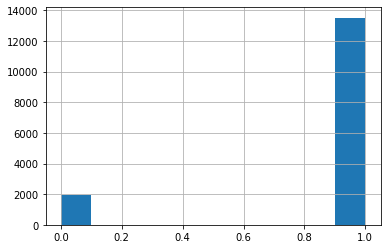

In [2]:
train_data.target.hist()

In [3]:
train_data.dropna(inplace=True)
train_data.shape

(15449, 3)

In [4]:
#!git clone https://github.com/anastasiya-zhiboedova/paraphrases.git

In [5]:

# user_session_million_queries_SMALL = pd.read_json('SMALL_user_session_million_queries.json', lines=True) #debug only
# user_session_million_queries_dataset = pd.read_json('user_session_million_queries.json',  lines=True)

test_data = pd.read_csv('test_dataset.csv', index_col=0).rename(columns={'query1': 'text_1', 'query2': 'text_2'})

val_data = pd.read_csv('paraphrases/data/revealed_set.csv', index_col=0).rename(columns={'query1': 'text_1', 'query2': 'text_2', 'class' :'target'})
val_data.index.name = None

val_data.shape

(50, 3)

In [6]:
from sklearn.model_selection import train_test_split

train_data, additional_val = train_test_split(train_data, test_size = 0.23, shuffle=True)
train_data.shape, additional_val.shape

((11895, 3), (3554, 3))

In [7]:
val_data = pd.concat([val_data, additional_val])

train_data.shape, val_data.shape

((11895, 3), (3604, 3))

## Modeling

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import display, clear_output
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, f1_score

from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import AdamW

from torch.utils.data import DataLoader
from transformers import get_scheduler

import pytorch_lightning as pl


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
model = torch.hub.load(
    'huggingface/pytorch-transformers', 
    'modelForSequenceClassification', 
    'bert-base-multilingual-cased'
)

tokenizer = torch.hub.load(
    'huggingface/pytorch-transformers', 
    'tokenizer', 
    'bert-base-multilingual-cased'
)

Using cache found in /home/alekseyen/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification 

In [10]:
class QueriesDataset(Dataset):
    def __init__(self, 
                 data, 
                 tokenizer,
                 col_one = 'text_1',
                 col_two = 'text_2',
                 target_column='target',
                 need_sort=True
                ):
        
        self.data = data
        self.target_column = target_column
        self.col_one = col_one
        self.col_two = col_two
        
        if need_sort:
            self.data['summary_len'] = self.data[col_one].apply(len) + self.data[col_two].apply(len)
            self.data.sort_values(by='summary_len', inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        results = tokenizer(
            text = self.data.iloc[index][self.col_one], 
            text_pair = self.data.iloc[index][self.col_two], 
            add_special_tokens=True,
            return_tensors='pt', 
            padding="max_length"
            # padding=True
    )
        results = {key: value.squeeze(0) for key, value in results.items()}
        
        if self.target_column in self.data.columns:
            true_classes = self.data.iloc[index][self.target_column]
            results['labels'] = torch.Tensor((1 - true_classes, true_classes))

        return results


In [11]:
train_dataset = QueriesDataset(train_data, tokenizer=tokenizer)

small_test_dataset = QueriesDataset(test_data, tokenizer=tokenizer)
# full_test_dataset = QueriesDataset(test_data, tokenizer=tokenizer) <- когда доедет пул
val_dataset = QueriesDataset(val_data, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(small_test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
# train_dataset = QueriesDataset(val_dataset, tokenizer=tokenizer)
# test_dataset = QueriesDataset(test_dataset, tokenizer=tokenizer)
# dt = DataLoader(train_dataset, batch_size=1, shuffle=True)

# model(next(iter(dt)))

In [13]:
from datasets import load_metric

class BertBasedModel(pl.LightningModule):
    def __init__(self, embeder_model, freeze_bert=False, lr=1e-5):
        super().__init__()

        self.embedder = embeder_model
        self.lr = lr
        self.val_metric = load_metric("accuracy")

    def forward(self, x):
        return self.embedder(**x)

    def training_step(self, batch):
        train_loss = self(batch).loss
        self.log("train_loss", train_loss, prog_bar=False, logger=True)
        
        return train_loss

    def validation_step(self, batch, batch_nb):
        logits = self(batch).logits
        predictions = torch.argmax(logits, dim=-1)
        self.val_metric.add_batch(predictions= predictions, references=torch.argmax(batch["labels"], dim=-1))
        
        val_metric = self.val_metric.compute()
        self.log("val_metric", val_metric, prog_bar=True, logger=True)
        
        return val_metric

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr)
        return [optimizer]


In [14]:
# from torch.multiprocessing import Pool, Process, set_start_method

# set_start_method('forkserver', force=True)

In [15]:
pl.seed_everything(1337, workers=True)

early_stop_callback = pl.callbacks.EarlyStopping(
        monitor="val_metric",
        min_delta=0.0001,
        patience=10,
        verbose=True,
        mode="max"
    )

model = torch.hub.load(
    'huggingface/pytorch-transformers', 
    'modelForSequenceClassification', 
    'bert-base-multilingual-cased'
)

bert_based_model = BertBasedModel(model)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback],
    log_every_n_steps=1,
)

Global seed set to 1337
Using cache found in /home/alekseyen/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFo

In [ ]:
trainer.fit(bert_based_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name     | Type                          | Params
-----------------------------------------------------------
0 | embedder | BertForSequenceClassification | 177 M 
-----------------------------------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
711.420   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Training: 0it [00:00, ?it/s]

In [ ]:
# %load_ext tensorboard
# # %reload_ext tensorboard

# %tensorboard --logdir /home/alekseyen/deep_vision_and_graphics/CraudNlpProject/lightning_logs

In [ ]:
def evaluate_model(model, test_dataloader):
    metric = load_metric("accuracy")
    progress_bar = tqdm(test_dataloader)
    
    model.eval()
    for batch in progress_bar:
        
        with torch.no_grad():
            outputs = model({k: v.to(device) for k, v in batch.items()})

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=torch.argmax(batch["labels"], dim=-1))
        progress_bar.update(1)

    progress_bar.close()

    return metric.compute()

evaluate_model(bert_based_model, val_dataloader) 

In [33]:
test_data = pd.read_csv('test_dataset.csv', index_col=0).rename(columns={'query1': 'text_1', 'query2': 'text_2'})
final_test_dataset = QueriesDataset(test_data, tokenizer=tokenizer, need_sort=False)
test_dataloader = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

In [37]:
progress_bar = tqdm(test_dataloader)

predictions = []

model.eval()
for batch in test_dataloader:
    with torch.no_grad():
        outputs = bert_based_model({k: v.to(device) for k, v in batch.items()})

    predictions.append(torch.argmax(outputs.logits, dim=-1).detach().cpu().numpy())
    progress_bar.update(1)

progress_bar.close()

predictions = np.concatenate(predictions)

  0%|          | 0/16 [00:00<?, ?it/s]

In [39]:
test_data['class'] = predictions

test_data.rename(columns={'text_1': 'query1', 'text_2': 'query2'}).to_csv('test_dataset_LABELED.csv', index=None)